<a href="https://colab.research.google.com/github/TanmayANP/Digit_Recognition/blob/main/digit_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Standard imports and load dataset

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load MNIST dataset
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()
print('The shape of training set is :', X_train_full.shape)

11501568/11490434 [==============================] - 0s 0us/step
The shape of training set is : (60000, 28, 28)


# Spliting the dataset into train, test and validation sets

In [2]:
# Train, test, valid split
X_train, X_val = X_train_full[5000:]/255.0, X_train_full[:5000]/255.0
y_train, y_val = y_train_full[5000:], y_train_full[:5000]
X_test = X_test/255.0

# Create channel for gray scale
X_train = X_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]
X_test = X_test[..., np.newaxis]

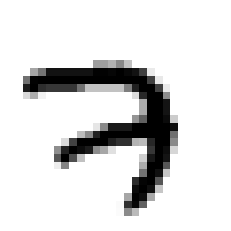

In [3]:
# Visualizing single digit
img = X_train[0]
plt.imshow(img.reshape((28, 28)), cmap=mpl.cm.binary)
plt.axis('off')
plt.show()

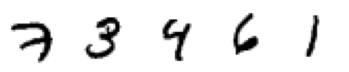

In [4]:
# Visualizing multiple digits
n_images = 5
for i in range(n_images):
  plt.subplot(1, n_images, i+1)
  img = X_train[i]
  plt.imshow(img.reshape((28, 28)), cmap=mpl.cm.binary)
  plt.axis('off')

plt.show()

# Create and summarize model

In [5]:
model = keras.models.Sequential(
    [
     keras.layers.Conv2D(10, 7, activation='relu', padding='same', input_shape=[28,28, 1]),
     keras.layers.Conv2D(16, 6, activation='relu', padding='same'),
     keras.layers.MaxPool2D(2),
     keras.layers.Conv2D(64, 5, activation='relu', padding='same'),
     keras.layers.MaxPool2D(2),
     keras.layers.Conv2D(256, 4, activation='relu', padding='same'),
     keras.layers.MaxPool2D(2),
     keras.layers.Conv2D(256, 3, activation='relu'),
     keras.layers.GlobalAveragePooling2D(),
     keras.layers.Dropout(0.5),
     keras.layers.Flatten(),
     keras.layers.Dropout(0.5),
     keras.layers.Dense(10, activation='softmax')
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 10)        500       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 16)        5776      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        25664     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 256)         262400    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 256)         0

# Datagenerator with on spot augmentation

In [6]:
train_datagen = ImageDataGenerator(rotation_range=30,
                                   width_shift_range=2,
                                   height_shift_range=2,
                                   cval=0,
                                   fill_mode='constant')

valid_datagen = ImageDataGenerator()

In [7]:
train_datagen.fit(X_train)
valid_datagen.fit(X_train)

# Model fitting

In [8]:
# Learning rate scheduling
lr_scheduler = keras.optimizers.schedules.ExponentialDecay(0.001, decay_steps=5000, decay_rate=0.5, staircase=True)
optimizer = keras.optimizers.Adam(learning_rate=lr_scheduler)

# Compiling model
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Early stopping callback
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

# Model fitting
history = model.fit(train_datagen.flow(X_train, y_train, batch_size=32),
                    epochs=100,
                    validation_data=valid_datagen.flow(X_val, y_val, batch_size=32),
                    callbacks=[early_stopping_cb])

Epoch 1/100
1719/1719 [==============================] - 68s 22ms/step - loss: 0.3630 - accuracy: 0.8866 - val_loss: 0.0670 - val_accuracy: 0.9806
Epoch 2/100
1719/1719 [==============================] - 37s 21ms/step - loss: 0.1107 - accuracy: 0.9703 - val_loss: 0.0509 - val_accuracy: 0.9846
Epoch 3/100
1719/1719 [==============================] - 37s 21ms/step - loss: 0.0859 - accuracy: 0.9766 - val_loss: 0.0312 - val_accuracy: 0.9924
Epoch 4/100
1719/1719 [==============================] - 37s 21ms/step - loss: 0.0590 - accuracy: 0.9847 - val_loss: 0.0255 - val_accuracy: 0.9936
Epoch 5/100
1719/1719 [==============================] - 38s 22ms/step - loss: 0.0507 - accuracy: 0.9863 - val_loss: 0.0244 - val_accuracy: 0.9936
Epoch 6/100
1719/1719 [==============================] - 37s 22ms/step - loss: 0.0464 - accuracy: 0.9873 - val_loss: 0.0247 - val_accuracy: 0.9938
Epoch 7/100
1719/1719 [==============================] - 37s 22ms/step - loss: 0.0363 - accuracy: 0.9907 - val_loss: 0

# Visualizing learning curves

Minimum validation loss: 0.014978068880736828




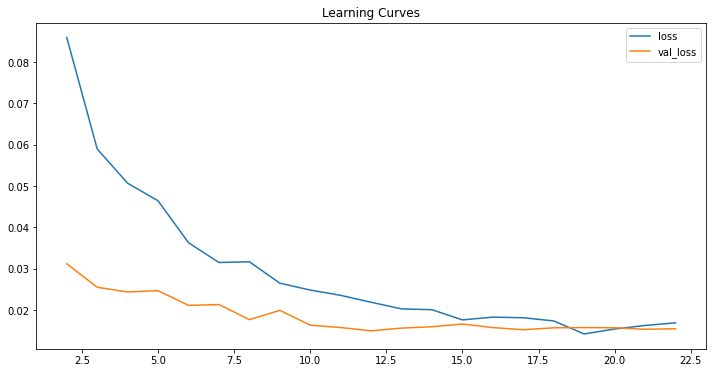

In [9]:
history_df = pd.DataFrame(history.history)
print('Minimum validation loss: {}\n\n'.format(history_df['val_loss'].min()))

# Learning curve is focused at the later stages of training
history_df.loc[2:, ['loss', 'val_loss']].plot(title='Learning Curves', figsize=(12, 6));

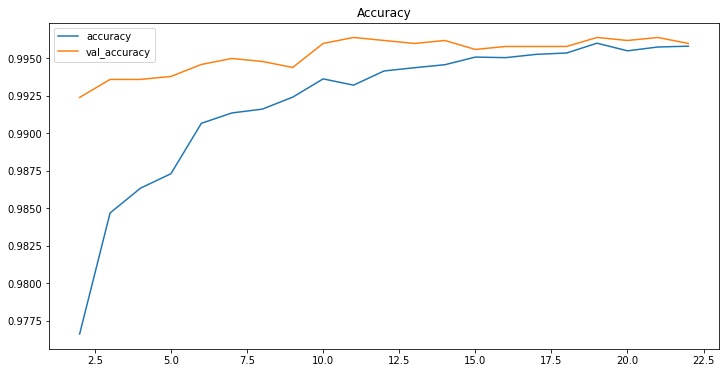

In [10]:
history_df.loc[2:, ['accuracy', 'val_accuracy']].plot(title='Accuracy', figsize=(12, 6));

# Score on test data

In [11]:
print(model.evaluate(X_test, y_test))

313/313 [==============================] - 2s 7ms/step - loss: 0.0156 - accuracy: 0.9952
[0.015619363635778427, 0.995199978351593]
